In [1]:
import os
import sys
import csv
import textwrap
import warnings

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from utils.checkpoint import load_params

from model.train.recommender import optimize_users

warnings.simplefilter("ignore")

#### Load Embeddings

In [2]:
params = load_params("../artifacts/model/32m_users_training_features_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [3]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [4]:
params = load_params("../artifacts/model/32m_users_training_10.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

In [5]:
params = load_params("../artifacts/model/32m_users_training_features_10.npz")
user_bias_with_f = params["user_bias"]
movie_bias_with_f = params["movie_bias"]
user_embeddings_with_f = params["user_embedding"]
movie_embeddings_with_f = params["movie_embedding"]

#### Load Data

In [6]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}
movie_id_to_genres = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, genres = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id
        movie_id_to_genres[movie_id] = genres

#### Movie Embedding Space

In [7]:
idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

In [8]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings" in idx_to_title[x].lower())
            or ("fifty shades" in idx_to_title[x].lower())
            or ("despicable me" in idx_to_title[x].lower())
            or ("hotel transylvania" in idx_to_title[x].lower())
        ),
        range(len(movie_user))
    )
)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


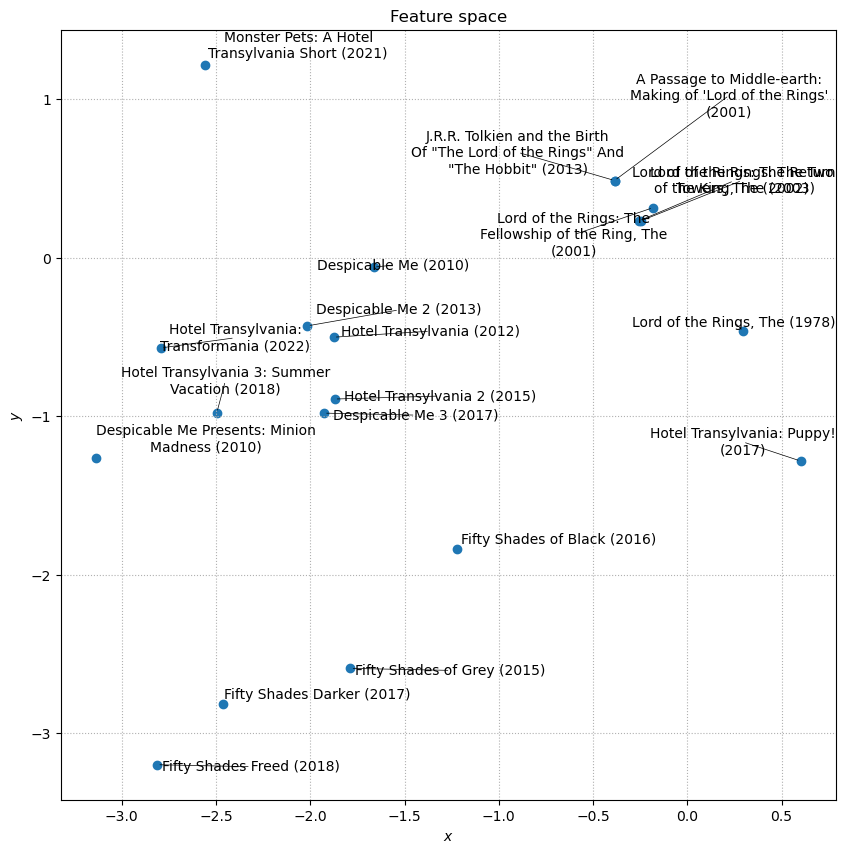

In [9]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Feature Embedding Space

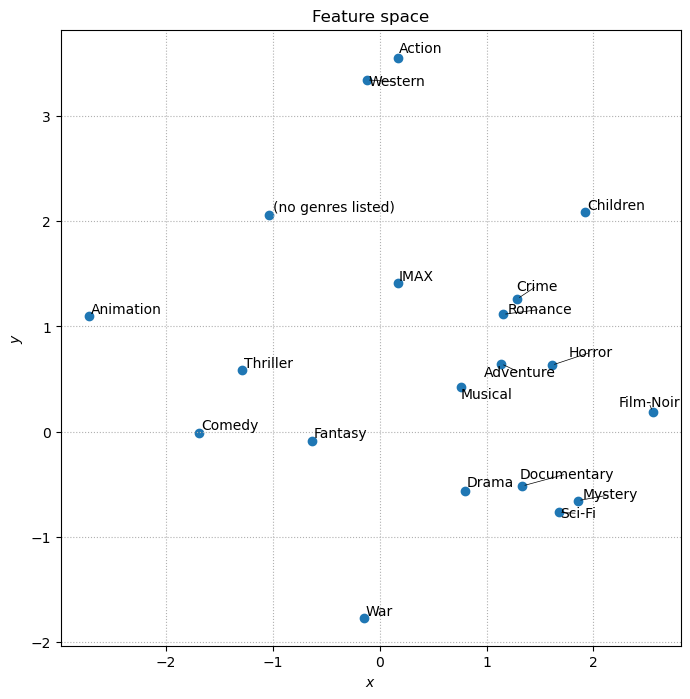

In [10]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Dummy User Embedding

In [11]:
lord_of_the_ring_title = "Lord of the Rings: The Fellowship of the Ring, The (2001)"
lord_of_the_ring_id = title_to_movie_id[lord_of_the_ring_title]
lord_of_the_ring_rating = 5.0
lord_of_the_ring_idx = movie_id_to_idx[lord_of_the_ring_id]

print(f"Movie: {lord_of_the_ring_title}")
print(f"Degree: {len(movie_user[lord_of_the_ring_idx][0])}")
print(f"Genres: {movie_id_to_genres[lord_of_the_ring_id]}")

Movie: Lord of the Rings: The Fellowship of the Ring, The (2001)
Degree: 73122
Genres: Adventure|Fantasy


In [12]:
dummy_id = "dummy"
dummy_idx = len(user_id_to_idx)
user_id_to_idx[dummy_id] = dummy_idx
idx_to_user_id.append(dummy_id)

user_movie.append((
    [lord_of_the_ring_idx], [lord_of_the_ring_rating]
))

movie_user[lord_of_the_ring_idx][0].append(dummy_idx)
movie_user[lord_of_the_ring_idx][1].append(lord_of_the_ring_rating)

user_embeddings = np.vstack([user_embeddings, np.random.normal(0, np.sqrt(user_embeddings.shape[1]), (user_embeddings.shape[1]))])
user_bias = np.hstack([user_bias, np.random.randn()])

user_embeddings_with_f = np.vstack([user_embeddings_with_f, np.random.normal(0, np.sqrt(user_embeddings_with_f.shape[1]), (user_embeddings_with_f.shape[1]))])
user_bias_with_f = np.hstack([user_bias_with_f, np.random.randn()])

assert len(user_embeddings) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_embeddings_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"

In [13]:
for i in range(len(user_movie)):
    user_movie[i] = (
        np.array(user_movie[i][0], dtype=int),
        np.array(user_movie[i][1], dtype=np.float64),
    )

for i in range(len(movie_user)):
    movie_user[i] = (
        np.array(movie_user[i][0], dtype=int),
        np.array(movie_user[i][1], dtype=np.float64),
    )

In [14]:
old_embedding = user_embeddings[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias,
        movie_bias,
        user_embeddings[dummy_idx, np.newaxis],
        movie_embeddings
    )

assert ((old_embedding - user_embeddings[dummy_idx]) > 1e-2).any(), "Embedding not updated"

In [15]:
old_embedding = user_embeddings_with_f[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings_with_f.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias_with_f,
        movie_bias_with_f,
        user_embeddings_with_f[dummy_idx, np.newaxis],
        movie_embeddings_with_f
    )

assert ((old_embedding - user_embeddings_with_f[dummy_idx]) > 1e-2).any(), "Embedding not updated"

#### Top 10 Prediction for Dummy User

In [16]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Guilt (2020)  - degree: 1  - genres: Thriller
2 - The Lady in the Walls (2014)  - degree: 1  - genres: Horror
3 - The Maid (2005)  - degree: 1  - genres: Drama|Horror|Thriller
4 - Beautiful Days (1955)  - degree: 2  - genres: Drama
5 - Nature Unleashed: Avalanche (2004)  - degree: 2  - genres: Action|Adventure|Thriller
6 - The Singing Revolution (2006)  - degree: 1  - genres: Documentary
7 - Happy Birthday (2016)  - degree: 1  - genres: Horror|Thriller
8 - Clownwise (2013)  - degree: 2  - genres: Comedy|Drama
9 - Do Paise Ki Dhoop, Chaar Aane Ki Baarish (2009)  - degree: 1  - genres: Drama
10 - The Liberation of Skopje (2016)  - degree: 2  - genres: Drama


In [17]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - Happy Birthday (2016)  - degree: 1  - genres: Horror|Thriller
2 - Guilt (2020)  - degree: 1  - genres: Thriller
3 - Modern Musketeer, A (1917)  - degree: 1  - genres: Adventure|Comedy|Western
4 - Fertile Ground (2011)  - degree: 1  - genres: Horror
5 - Moomintroll and the Comet (1978)  - degree: 2  - genres: Animation|Children
6 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
7 - Go Ahead, Brazil! (1982)  - degree: 1  - genres: Crime|Drama
8 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
9 - Colossus of the Arena (1962)  - degree: 1  - genres: Action|Adventure|Drama
10 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123  - genres: Adventure|Fantasy


In [18]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123  - genres: Adventure|Fantasy
4 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
5 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
6 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
7 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
8 - Star Wars: The Last Jedi (2017)  - degree: 6646  - genres: Action|Adventure|Fantasy|Sci-Fi
9 - Avengers: Infinity War - Part II (2019)  - degree: 11811  - genres: Action|Adventure|Sci-Fi
10 - Star Wa

#### Top 10 Prediction for Dummy User [with features]

In [19]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Guilt (2020)  - degree: 1  - genres: Thriller
2 - The Lady in the Walls (2014)  - degree: 1  - genres: Horror
3 - The Maid (2005)  - degree: 1  - genres: Drama|Horror|Thriller
4 - Do Paise Ki Dhoop, Chaar Aane Ki Baarish (2009)  - degree: 1  - genres: Drama
5 - Nature Unleashed: Avalanche (2004)  - degree: 2  - genres: Action|Adventure|Thriller
6 - Nurnberg (2023)  - degree: 1  - genres: Drama
7 - Beautiful Days (1955)  - degree: 2  - genres: Drama
8 - Ouija Seance: The Final Game (2018)  - degree: 1  - genres: Horror
9 - 줄탁동시 (2012)  - degree: 2  - genres: (no genres listed)
10 - IMAX - The Dream Is Alive (1985)  - degree: 3  - genres: Documentary


In [20]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - Pokémon the Movie: Hoopa and the Clash of Ages (2015)  - degree: 23  - genres: Action|Adventure|Animation
2 - Ουζερί Τσιτσάνης  - degree: 11  - genres: (no genres listed)
3 - The Asylum (2016)  - degree: 12  - genres: Action|Horror|Mystery|Sci-Fi|Thriller
4 - Past Death (2020)  - degree: 1  - genres: Thriller
5 - Awakening (2008)  - degree: 5  - genres: (no genres listed)
6 - CzechMate: In Search of Jiří Menzel (2018)  - degree: 1  - genres: Documentary
7 - Attack on Titan: Chronicle (2020)  - degree: 26  - genres: Action|Adventure|Animation|Fantasy
8 - Appleseed: Ex Machina (2007)  - degree: 51  - genres: Action|Animation|Sci-Fi|Thriller
9 - Anacronte (2019)  - degree: 2  - genres: (no genres listed)
10 - World Builder (2007)  - degree: 17  - genres: (no genres listed)


In [21]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]
1 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
2 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
3 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
4 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
5 - Star Wars: The Last Jedi (2017)  - degree: 6646  - genres: Action|Adventure|Fantasy|Sci-Fi
6 - Avengers: Infinity War - Part II (2019)  - degree: 11811  - genres: Action|Adventure|Sci-Fi
7 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123  - genres: Adventure|Fantasy
8 - Avengers: Age of Ultron (2015)  - degree: 12099  - genres: Action|Adventure|Sci-Fi
9 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
10 - Batman v Superman: Dawn of J

#### Top Polarizing Movies

In [22]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm")

for i, idx in enumerate(reversed(movie_embedding_norm[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 20 Movie by embedding norm
1 - Fateful Findings (2013)  - degree: 79
2 - Twisted Pair (2018)  - degree: 31
3 - Begum Jaan (2017)  - degree: 2
4 - Он вам не Димон (2017)  - degree: 58
5 - Man Who Saves the World, The (Dünyayi Kurtaran Adam) (1982)  - degree: 67
6 - Summer Place Wanted (1957)  - degree: 1
7 - Jecão... Um Fofoqueiro no Céu (1977)  - degree: 1
8 - Prem Ratan Dhan Payo (2015)  - degree: 25
9 - Nude Nuns with Big Guns (2010)  - degree: 47
10 - Space Cop (2016)  - degree: 41
11 - Kevin Smith: Sold Out - A Threevening with Kevin Smith (2008)  - degree: 42
12 - The Girl in Room 2A (1974)  - degree: 1
13 - Kindar the Invulnerable (1965)  - degree: 1
14 - Hillary's America: The Secret History Of The Democratic Party (2016)  - degree: 29
15 - Brexit: The Movie (2016)  - degree: 15
16 - Love on a Leash (2011)  - degree: 17
17 - Seemaraja (2018)  - degree: 1
18 - Poultrygeist: Night of the Chicken Dead (2006)  - degree: 130
19 - Samurai Cop (1989)  - degree: 107
20 - KonoSuba: G

In [23]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm [< 500 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 20 Movie by embedding norm [< 500 rating filtering]
1 - Twilight Saga: Breaking Dawn - Part 1, The (2011)  - degree: 2703
2 - Twilight Saga: Breaking Dawn - Part 2, The (2012)  - degree: 2362
3 - Twilight Saga: Eclipse, The (2010)  - degree: 4060
4 - Movie 43 (2013)  - degree: 844
5 - Twilight Saga: New Moon, The (2009)  - degree: 4038
6 - Room, The (2003)  - degree: 1179
7 - Saw VI (2009)  - degree: 1443
8 - Saw VII 3D - The Final Chapter (2010)  - degree: 1094
9 - Transformers: Revenge of the Fallen (2009)  - degree: 5626
10 - Last Airbender, The (2010)  - degree: 2036
11 - Justice League (2017)  - degree: 2382
12 - Avengers: Infinity War - Part II (2019)  - degree: 11811
13 - Star Wars: The Rise of Skywalker (2019)  - degree: 3062
14 - Transformers: Age of Extinction (2014)  - degree: 2167
15 - Transformers: Dark of the Moon (2011)  - degree: 3976
16 - Saw IV (2007)  - degree: 2514
17 - Batman v Superman: Dawn of Justice (2016)  - degree: 4547
18 - Cars 2 (2011)  - degree: 2402


In [24]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Top 20 Movie by embedding norm [cosine similarity filtering + < 500 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break  
    if idx in filtering:
        continue
        
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Top 20 Movie by embedding norm [cosine similarity filtering + < 500 rating filtering]
1 - Twilight Saga: Breaking Dawn - Part 1, The (2011)  - degree: 2703
2 - Movie 43 (2013)  - degree: 844
3 - Room, The (2003)  - degree: 1179
4 - Saw VI (2009)  - degree: 1443
5 - Transformers: Revenge of the Fallen (2009)  - degree: 5626
6 - Avengers: Infinity War - Part II (2019)  - degree: 11811
7 - Star Wars: The Rise of Skywalker (2019)  - degree: 3062
8 - Freddy Got Fingered (2001)  - degree: 2105
9 - Tetsuo, the Ironman (Tetsuo) (1988)  - degree: 840
10 - Serbian Film, A (Srpski film) (2010)  - degree: 771
11 - Plan 9 from Outer Space (1959)  - degree: 2521
12 - Ted 2 (2015)  - degree: 2169
13 - Antichrist (2009)  - degree: 2290
14 - Minions (2015)  - degree: 3225
15 - What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004)  - degree: 729
16 - Pootie Tang (2001)  - degree: 615
17 - Human Centipede, The (First Sequence) (2009)  - degree: 1159
18 - Spider-Man: Across the Spider-Ver

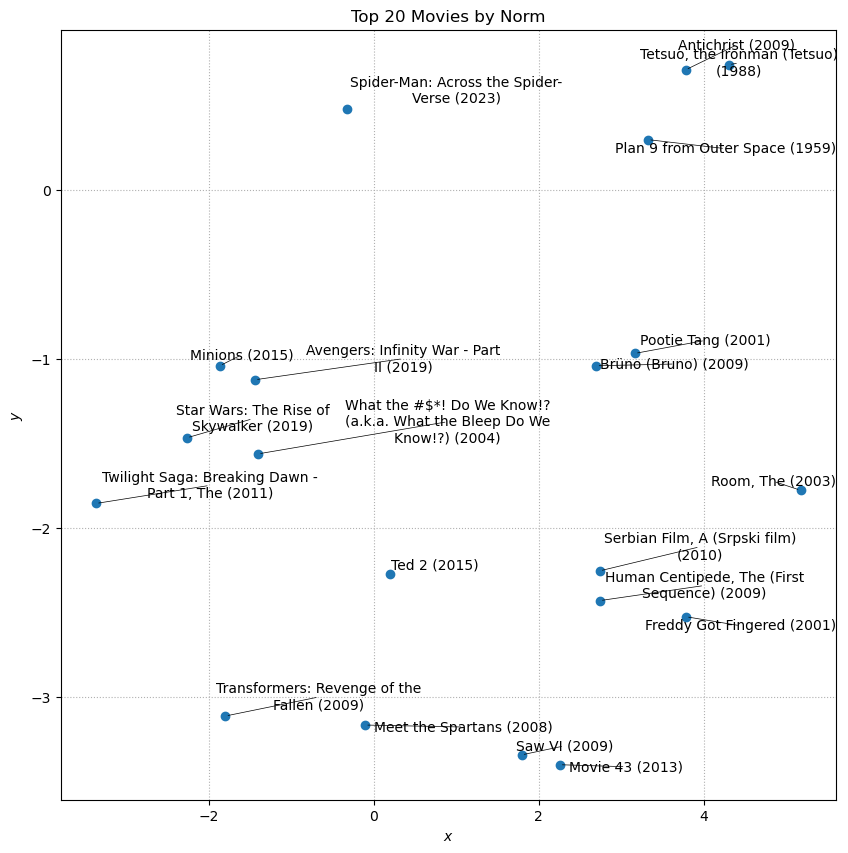

In [25]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Top 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/top_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Less Polarizing Movies

In [26]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm")

for i, idx in enumerate(movie_embedding_norm[:20]):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Bottom 20 Movie by embedding norm
1 - Guilty Pleasures (2010)  - degree: 1
2 - Another World (2018)  - degree: 1
3 - Tori and Lokita (2022)  - degree: 3
4 - The Arrival (2017)  - degree: 1
5 - Whenever You're Ready (2018)  - degree: 1
6 - Cul-De-Sac (2016)  - degree: 1
7 - The Clark Sisters: First Ladies of Gospel (2020)  - degree: 2
8 - My Broken Mariko (2022)  - degree: 1
9 - Four Sisters (1985)  - degree: 1
10 - Vaa Arugil Vaa (1991)  - degree: 1
11 - Operation Java (2021)  - degree: 1
12 - Cold Case (2021)  - degree: 1
13 - Sri Raghavendra (1985)  - degree: 1
14 - Ayya (2005)  - degree: 1
15 - Salim (2014)  - degree: 1
16 - Thambikku Entha Ooru (1984)  - degree: 1
17 - Samsaram Athu Minsaram (1986)  - degree: 1
18 - Rajaraja Cholan (1973)  - degree: 1
19 - Kadhalikka Neramillai (1964)  - degree: 1
20 - Tik Tik Tik (1981)  - degree: 1


In [27]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm [< 500 rating filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Bottom 20 Movie by embedding norm [< 500 rating filtering]
1 - Bear, The (Ours, L') (1988)  - degree: 1103
2 - Mr. Saturday Night (1992)  - degree: 729
3 - Philadelphia Experiment, The (1984)  - degree: 574
4 - Hollywoodland (2006)  - degree: 547
5 - Winter War (Talvisota) (1989)  - degree: 613
6 - New Jack City (1991)  - degree: 638
7 - Phenomena (a.k.a. Creepers) (1985)  - degree: 584
8 - For Your Consideration (2006)  - degree: 553
9 - High Anxiety (1977)  - degree: 523
10 - Emerald Forest, The (1985)  - degree: 1003
11 - Backbeat (1993)  - degree: 1160
12 - Tough Guys (1986)  - degree: 557
13 - Duel (1971)  - degree: 1468
14 - Death on the Nile (1978)  - degree: 810
15 - Purple Rain (1984)  - degree: 676
16 - Wait Until Dark (1967)  - degree: 1439
17 - Murder on the Orient Express (1974)  - degree: 1596
18 - My Week with Marilyn (2011)  - degree: 640
19 - Unlawful Entry (1992)  - degree: 585
20 - 3:10 to Yuma (1957)  - degree: 674


In [28]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Bottom 20 Movie by embedding norm [cosine similarity filtering + <500 ratings filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break 
    if idx in filtering:
        continue

    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Bottom 20 Movie by embedding norm [cosine similarity filtering + <500 ratings filtering]
1 - Bear, The (Ours, L') (1988)  - degree: 1103
2 - Mr. Saturday Night (1992)  - degree: 729
3 - Philadelphia Experiment, The (1984)  - degree: 574
4 - Hollywoodland (2006)  - degree: 547
5 - Winter War (Talvisota) (1989)  - degree: 613
6 - New Jack City (1991)  - degree: 638
7 - Phenomena (a.k.a. Creepers) (1985)  - degree: 584
8 - For Your Consideration (2006)  - degree: 553
9 - High Anxiety (1977)  - degree: 523
10 - Emerald Forest, The (1985)  - degree: 1003
11 - Backbeat (1993)  - degree: 1160
12 - Tough Guys (1986)  - degree: 557
13 - Duel (1971)  - degree: 1468
14 - Death on the Nile (1978)  - degree: 810
15 - Purple Rain (1984)  - degree: 676
16 - Wait Until Dark (1967)  - degree: 1439
17 - Murder on the Orient Express (1974)  - degree: 1596
18 - My Week with Marilyn (2011)  - degree: 640
19 - Unlawful Entry (1992)  - degree: 585
20 - 3:10 to Yuma (1957)  - degree: 674


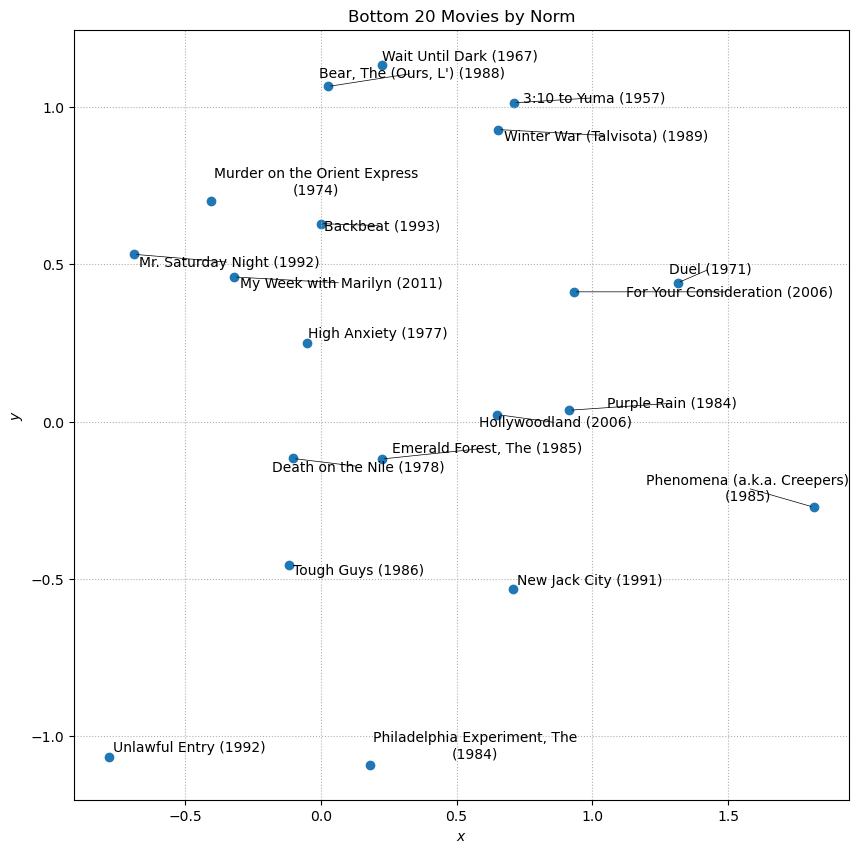

In [29]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Bottom 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/bottom_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

---